In [1]:
%matplotlib widget
from bmcs_cross_section.api import MKappa, EC2, ACI440, AnaFRPBending, ReinfLayer
import bmcs_utils.api as bu 
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

bu.set_latex_mpl_format()
plot_colors = bu.plot_colors

# Deriving the two-lines equations

Using a linear regression on data based on the parabolic EC2 stress-strain law of concrete

In [2]:
# EC2, eq. (3.14)

sig_c1, sig_c2, sig_c3, eps_cu1, b, d, A_f, f_fu, E_f, rho_f, sigma_f = \
 sp.symbols(r'\sigma_c1 \sigma_c2 \sigma_c3, \varepsilon_\mathrm{cu1}, b, d, A_\mathrm{f}, f_\mathrm{fu}, E_\mathrm{f}, \rho_\mathrm{f}, \sigma_\mathrm{f}', real=True, nonnegative=True)
eps_cy, eps_cu, eps, E_cc, f_cm, eps_1 = \
sp.symbols(r'\varepsilon_\mathrm{cy}, \varepsilon_\mathrm{cu}, \varepsilon, E_\mathrm{cc}, f_\mathrm{cm}, \varepsilon_\mathrm{1}', real=True, nonnegative=True)
kappa= sp.symbols(r'\kappa', real=True)

k = 1.05 * E_cc * eps_cy / f_cm
eta = eps / eps_cy
sig_c = f_cm * (k * eta - eta**2)/(1 + eta*(k-2))

sig_c_eps_ = sp.Piecewise(
        (0, eps > eps_cu),
        (sig_c, eps > 0),
        (0, True)
)

In [3]:
# # Comparison to EC2, multi-linear concept

# result2 = np.zeros((len(f_cms), 3))

# for i, f_cm_ in enumerate(f_cms):
#     sig_c_eps = sig_c_eps_.subs({E_cc:EC2.get_E_cm(f_cm_ - 8), eps_cy:eps_cy_, 
#                                 f_cm:EC2.get_f_cm(f_cm_ - 8), eps_cu:EC2.get_eps_cu1(f_cm_- 8)})
#     get_sig = sp.lambdify(eps, sig_c_eps, 'numpy')
#     eps_exact = np.linspace(0, eps_cy_, 300)
#     sig_exact = get_sig(eps_exact)
#     area_fine = np.trapz(y=sig_exact, x=eps_exact)
    
#     f_ck = f_cm_ - 8
#     eps_c3 = EC2.get_eps_c3(f_ck)
#     eps_cu3 = EC2.get_eps_cu3(f_ck)
#     area = eps_c3 * f_cm_ / 2 + (eps_cu3 - eps_c3) * f_cm_
    
#     result2[i, 0] = f_cm_
#     result2[i, 1] = area_fine
#     result2[i, 2] = area
# result2

In [4]:
# f_cms = np.array([ 20.,  24.,  28.,  33.,  38.,  43.,  48.,  53.,  58.,  63.,  68., 78.,  88.,  98., 108.])
f_cms = np.linspace(20, 108, 108 -20 +1)
result = np.zeros((len(f_cms), 3))

f_cm_limit = 98

for i, f_cm_ in enumerate(f_cms):
    eps_cy_ = EC2.get_eps_c1(f_cm_ - 8)
    eps_cu_ = EC2.get_eps_cu1(f_cm_- 8)

    sig_c_eps = sig_c_eps_.subs({E_cc:EC2.get_E_cm(f_cm_ - 8), eps_cy:eps_cy_, 
                                f_cm:EC2.get_f_cm(f_cm_ - 8), eps_cu:eps_cu_})
    get_sig = sp.lambdify(eps, sig_c_eps, 'numpy')
    
    eps_exact_part_1 = np.linspace(0, eps_cy_, 300)
    sig_exact_part_1 = get_sig(eps_exact_part_1)
    area_exact_part_1 = np.trapz(y=sig_exact_part_1, x=eps_exact_part_1)
    
    eps_exact_part_2 = np.linspace(eps_cy_, eps_cu_, 300)
    sig_exact_part_2 = get_sig(eps_exact_part_2)
    area_exact_part_2 = np.trapz(y=sig_exact_part_2, x=eps_exact_part_2)
    
    print('area_exact_part_2=', area_exact_part_2)

    sig_eps_c1_new = 2 * area_exact_part_1 / eps_cy_
    sig_eps_c1_scale = sig_eps_c1_new / f_cm_
    
    sig_eps_cu1_new = 2 * area_exact_part_2 / (eps_cu_ - eps_cy_) - sig_eps_c1_new
    sig_eps_cu1_scale = sig_eps_c1_scale if f_cm_ >= f_cm_limit else sig_eps_cu1_new / f_cm_
    
    result[i] = [f_cm_, sig_eps_c1_scale, sig_eps_cu1_scale]

result

area_exact_part_2= 0.02877701214730907
area_exact_part_2= 0.029815737674886583
area_exact_part_2= 0.030828691661410515
area_exact_part_2= 0.03181655570378753
area_exact_part_2= 0.03277995980757356
area_exact_part_2= 0.03371948824877098
area_exact_part_2= 0.034635684556817724
area_exact_part_2= 0.03552905577979381
area_exact_part_2= 0.03640007615840567
area_exact_part_2= 0.03724919030920936
area_exact_part_2= 0.03807681599757036
area_exact_part_2= 0.038883346565345735
area_exact_part_2= 0.039669153066218
area_exact_part_2= 0.040434586152065397
area_exact_part_2= 0.041179977746182116
area_exact_part_2= 0.04190564253309988
area_exact_part_2= 0.04261187928987349
area_exact_part_2= 0.043298972079707655
area_exact_part_2= 0.04396719132556892
area_exact_part_2= 0.04461679477875618
area_exact_part_2= 0.045248028395184936
area_exact_part_2= 0.0458611271303266
area_exact_part_2= 0.04645631566219391
area_exact_part_2= 0.04703380905049358
area_exact_part_2= 0.04759381333896968
area_exact_part_2= 0

C:\Users\hspartali\AppData\Local\Temp\ipykernel_17828\3539078300.py:28: RuntimeWarning: invalid value encountered in double_scalars
  sig_eps_cu1_new = 2 * area_exact_part_2 / (eps_cu_ - eps_cy_) - sig_eps_c1_new


area_exact_part_2= 1.7381249920273297e-05
area_exact_part_2= 3.639167925854229e-05
area_exact_part_2= 6.806834507738217e-05
area_exact_part_2= 0.00011722749446512867
area_exact_part_2= 0.00018954718026941464
area_exact_part_2= 0.000291599593403773


array([[ 20.        ,   1.40553767,   0.25961634],
       [ 21.        ,   1.39991292,   0.26927106],
       [ 22.        ,   1.39449986,   0.27864123],
       [ 23.        ,   1.38928082,   0.2877492 ],
       [ 24.        ,   1.38424032,   0.2966147 ],
       [ 25.        ,   1.37936465,   0.30525524],
       [ 26.        ,   1.37464167,   0.31368645],
       [ 27.        ,   1.37006055,   0.32192231],
       [ 28.        ,   1.36561157,   0.32997541],
       [ 29.        ,   1.36128601,   0.33785714],
       [ 30.        ,   1.35707598,   0.34557778],
       [ 31.        ,   1.35297435,   0.35314673],
       [ 32.        ,   1.34897462,   0.36057252],
       [ 33.        ,   1.34507086,   0.36786299],
       [ 34.        ,   1.34125767,   0.37502531],
       [ 35.        ,   1.33753008,   0.38206607],
       [ 36.        ,   1.33388352,   0.38899138],
       [ 37.        ,   1.33031378,   0.39580684],
       [ 38.        ,   1.32681699,   0.40251767],
       [ 39.        ,   1.32338

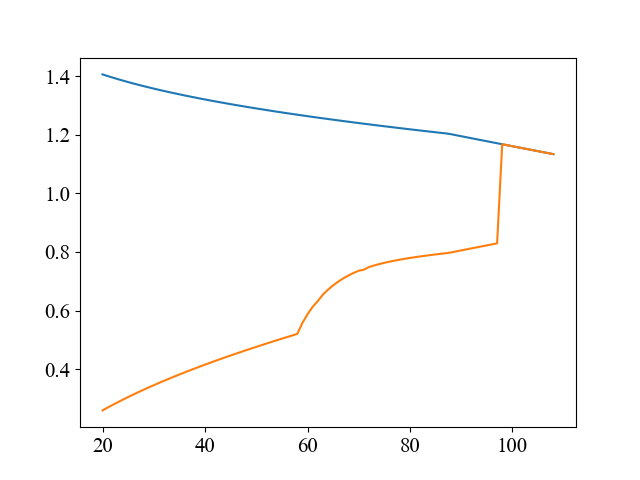

In [5]:
fig1, ax1 = plt.subplots()
ax1.plot(result[:, 0], result[:, 1])
ax1.plot(result[:, 0], result[:, 2])

In [6]:
# Linear regression using numpy

m1, p1 = np.polyfit(result[:, 0], result[:, 1], 1)
sig_cy_scale = m1 * f_cm + p1

# Exclude f_cm >= f_cm_limit from curve fitting
f_cms_less_than_limit = result[:, 0][result[:, 0] < f_cm_limit]
sig_eps_cu1_scale_for_f_cms_less_than_limit = result[:, 2][result[:, 0] < f_cm_limit]
m2, p2 = np.polyfit(f_cms_less_than_limit, sig_eps_cu1_scale_for_f_cms_less_than_limit, 1)
sig_cu_scale = m2 * f_cm + p2

sig_cy_scale, sig_cu_scale

(1.43762037986179 - 0.00278582241716739*f_\mathrm{cm},
 0.00822753426311965*f_\mathrm{cm} + 0.0955313938528226)

In [7]:
get_sig_cy_scale = sp.lambdify(f_cm, sig_cy_scale, 'numpy')
get_sig_cu_scale = sp.lambdify(f_cm, sig_cu_scale, 'numpy')

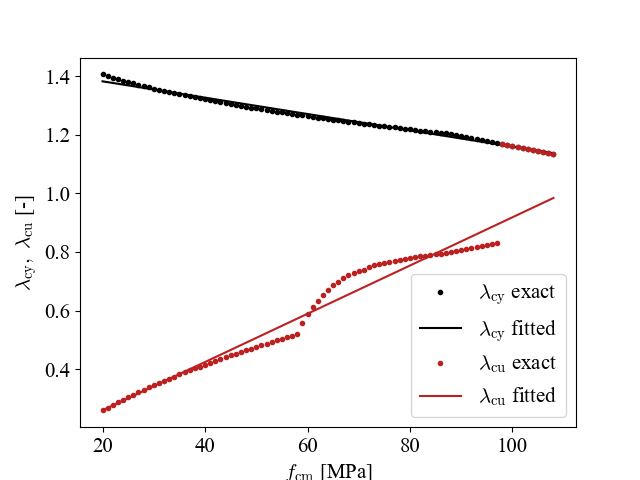

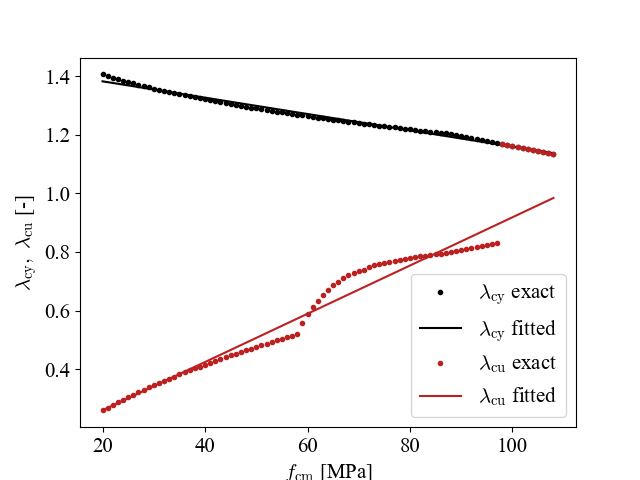

In [8]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('$f_\mathrm{cm}$ [MPa]')
ax1.set_ylabel('$\lambda_\mathrm{cy},\;\lambda_\mathrm{cu}$ [-]')

# ax1.plot(result[:, 0], result[:, 1], '--', label='$\lambda_\mathrm{cy}$ exact', color=plot_colors[0])
ax1.plot(result[:, 0], result[:, 1], 'o', markersize=3, label='$\lambda_\mathrm{cy}$ exact', color=plot_colors[0])
ax1.plot(result[:, 0], get_sig_cy_scale(result[:, 0]), label='$\lambda_\mathrm{cy}$ fitted', color=plot_colors[0])

# ax1.plot(result[:, 0], result[:, 2], '--', label='$\lambda_\mathrm{cu}$ exact', color=plot_colors[1])
ax1.plot(result[:, 0], result[:, 2], 'o', markersize=3, label='$\lambda_\mathrm{cu}$ exact', color=plot_colors[1])
ax1.plot(result[:, 0], get_sig_cu_scale(result[:, 0]), label='$\lambda_\mathrm{cu}$ fitted', color=plot_colors[1])

ax1.legend()
fig1.show()

In [9]:
# fig1.savefig('f_cm_vs_sigma_cy_scale_sigma_cu_scale.pdf')

area_approx = 0.14279697384496404
area_exact = 0.1427964249293711
area_diff [%] = -0.0003844042966729845


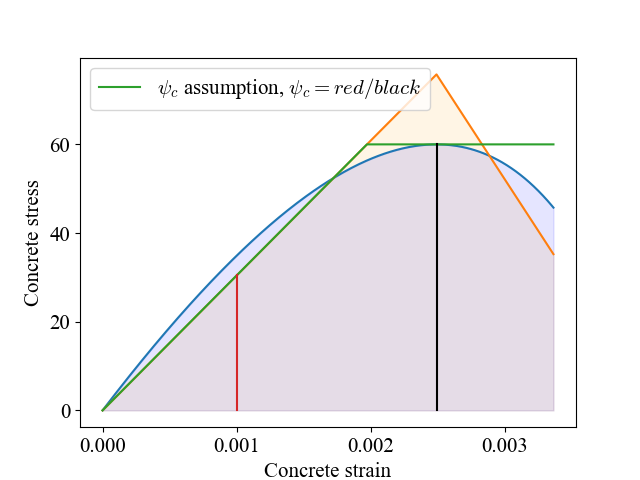

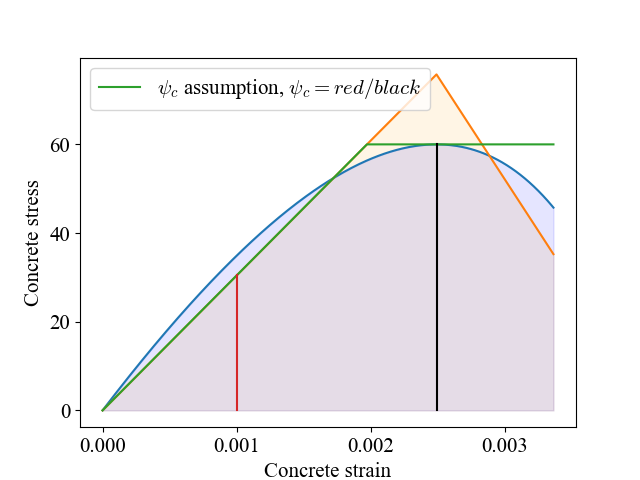

In [10]:
# Just for checking..

fig, ax = plt.subplots()

for f_cm_ in [60]: # f_cms:
    eps_cy_ = EC2.get_eps_c1(f_cm_ - 8)
    eps_cu_ = EC2.get_eps_cu1(f_cm_ - 8)
    sig_c_eps = sig_c_eps_.subs({E_cc:EC2.get_E_cm(f_cm_ - 8), eps_cy:eps_cy_, 
                                f_cm:f_cm_, eps_cu:eps_cu_})
    get_sig = sp.lambdify(eps, sig_c_eps, 'numpy')
    
    eps_exact = np.linspace(0, eps_cu_, 300)
    sig_exact = get_sig(eps_exact)
    
    sigma_cm_cy_scale = result[np.argwhere(result[:, 0] == f_cm_)[0]][0][1]
    sigma_cm_cu_scale = result[np.argwhere(result[:, 0] == f_cm_)[0]][0][2]
    eps_coarse = np.array([0., eps_cy_, eps_cu_])
    sig_coarse = np.array([0., f_cm_ * sigma_cm_cy_scale, f_cm_ * sigma_cm_cu_scale])
    
    area_approx = np.trapz(y=sig_coarse, x=eps_coarse)
    area_exact = np.trapz(y=sig_exact, x=eps_exact)
    print('area_approx =', area_approx)
    print('area_exact =', area_exact)
    print('area_diff [%] =', (area_exact - area_approx) * 100 / area_exact)
    
    ax.fill_between(eps_coarse, sig_coarse, color= 'orange', alpha= 0.1)
    ax.fill_between(eps_exact, sig_exact, color= 'blue', alpha= 0.1)
    ax.set_xlabel('Concrete strain')
    ax.set_ylabel('Concrete stress')
    ax.plot(eps_exact, sig_exact)
    ax.plot(eps_coarse, sig_coarse)
    
    # Plot example lines
    eps_sig_coarse_equals_f_cm = np.interp(f_cm_, sig_coarse[:-1], eps_coarse[:-1])
    eps_coarse_psi = np.array([0, eps_sig_coarse_equals_f_cm, eps_cu_])
    sig_coarse_psi = np.array([0, f_cm_, f_cm_])
    eps_example = 0.001
    sig_example = np.interp(eps_example, eps_coarse, sig_coarse)
    
    ax.plot(eps_coarse_psi, sig_coarse_psi, label='$\psi_c$ assumption, $\psi_c = red/black$')
    ax.plot([eps_example, eps_example], [0, sig_example])
    ax.plot([eps_cy_, eps_cy_], [0, f_cm_], c='black')
    ax.legend()

fig.show()

In [11]:
# fig.savefig('stress_strain_concrete_curve_with_linear_approx.pdf')

# Deriving $M_u, \rho_\mathrm{fb}, \psi_c, \psi_f$ equations for the 2-lines-based material law

In [12]:
substitute_eps_cy = False
substitute_scaled_stress = False

if substitute_eps_cy:
    eps_cy = 0.001 * sp.Min(0.7 * f_cm ** 0.31, 2.8) # 0.001 * 0.7 * f_cm ** 0.31
    eps_cu = 0.001 * sp.Piecewise(
        (3.5, f_cm <= 58), 
        (2.8 + 27 * ((98 - f_cm) / 100) ** 4, True)
)
    
# Don't substitute scaled_stress as it makes formulas longer and not any better!
if substitute_scaled_stress:
    sig_cy_scaled = f_cm * sig_cy_scale
    sig_cu_scaled = f_cm * sig_cu_scale
else:
    sig_cy_scaled, sig_cu_scaled = sp.symbols(r'\sigma_\mathrm{cy}, \sigma_\mathrm{cu}')

sig_line = sp.Line(sp.Point(0, 0), sp.Point(eps_cy, sig_cy_scaled))
sig_line2 = sp.Line(sp.Point(eps_cy, sig_cy_scaled), sp.Point(eps_cu, sig_cu_scaled))

sig_eq_1 = sig_line.equation(x=eps, y=sig_c1)
sig_eq1 = sp.solve(sig_eq_1, sig_c1)[0]

sig_eq_2 = sig_line2.equation(x=eps, y=sig_c2)
sig_eq2 = sp.solve(sig_eq_2, sig_c2)[0]

In [13]:
sig_eq = sp.Piecewise(
        (sig_eq1, eps <= eps_cy), 
        (sig_eq2, True)
)
sig_eq

Piecewise((\sigma_\mathrm{cy}*\varepsilon/\varepsilon_\mathrm{cy}, \varepsilon <= \varepsilon_\mathrm{cy}), ((\sigma_\mathrm{cu}*\varepsilon - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} - \sigma_\mathrm{cy}*\varepsilon + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cu})/(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}), True))

In [14]:
sig_eq_area = sp.integrate(sp.simplify(sig_eq), eps)
sig_eq_area

Piecewise((\sigma_\mathrm{cy}*\varepsilon**2/(2*\varepsilon_\mathrm{cy}), \varepsilon <= \varepsilon_\mathrm{cy}), (\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}/2 + \varepsilon**2*(\sigma_\mathrm{cu} - \sigma_\mathrm{cy})/(2*\varepsilon_\mathrm{cu} - 2*\varepsilon_\mathrm{cy}) + \varepsilon*(-\sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cu})/(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}) - \varepsilon_\mathrm{cy}**2*(\sigma_\mathrm{cu} - \sigma_\mathrm{cy})/(2*\varepsilon_\mathrm{cu} - 2*\varepsilon_\mathrm{cy}) - \varepsilon_\mathrm{cy}*(-\sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cu})/(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}), True))

In [15]:
# sp.simplify(sig_eq_area).subs({eps_cu - eps_cy: d_eps})

In [16]:
area_up_to_eps_part_1 = sig_eq_area.args[0][0]
area_up_to_eps_part_2 = sig_eq_area.args[1][0]

## Calculate $F_\mathrm{c, cy}$ and $\rho_\mathrm{f, cy}$ defining the switch from part 1 to 2

In [17]:
# Compare F_t = A_f * f_fu with F_c_cy, if F_t <= F_c_1, then use psi_c formula, otherwise psi_c = 1
# Note: one can also compare eps_top_solved with eps_cy, but the equation of eps_top_solved is more complicated
eps_fu = f_fu/E_f
c_1 = d * (eps_cy / (eps_cy + eps_fu))
F_c_cy = area_up_to_eps_part_1.subs({eps:eps_cy}) * (c_1 / eps_cy) * b
F_c_cy = sp.simplify(F_c_cy)
F_c_cy

E_\mathrm{f}*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}*b*d/(2*(E_\mathrm{f}*\varepsilon_\mathrm{cy} + f_\mathrm{fu}))

In [18]:
# rho corresponding to concrete block up to eps_cy
F_t_cy = A_f * f_fu
A_f_cy = sp.solve(F_c_cy - F_t_cy, A_f)[0]
rho_f_cy = A_f_cy /(b*d)
rho_f_cy

E_\mathrm{f}*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}/(2*f_\mathrm{fu}*(E_\mathrm{f}*\varepsilon_\mathrm{cy} + f_\mathrm{fu}))

In [19]:
sp.print_latex(rho_f_cy)

\frac{E_\mathrm{f} \sigma_\mathrm{cy} \varepsilon_\mathrm{cy}}{2 f_\mathrm{fu} \left(E_\mathrm{f} \varepsilon_\mathrm{cy} + f_\mathrm{fu}\right)}


### Final $\rho_\mathrm{f, cy}$ formula

$\rho_\mathrm{f, cy} = \frac{E_\mathrm{f} \sigma_\mathrm{cy} \varepsilon_\mathrm{cy}}{2 f_\mathrm{fu} \left(E_\mathrm{f} \varepsilon_\mathrm{cy} + f_\mathrm{fu}\right)}$

## $\psi_c$ for part 1

In [20]:
# Solving eps top for part 1
def get_eps_top_solved(index):
    c = d * eps/(eps + eps_fu)
    F_t = A_f * f_fu
    area_up_to_eps = area_up_to_eps_part_1 if index == 0 else area_up_to_eps_part_2
    sig_z_area = area_up_to_eps * (c / eps)
    F_c = sig_z_area * b
    eps_top_solved = sp.solve(F_t - F_c, eps)[1] # Note: this the positive solution
    eps_top_solved = sp.simplify(eps_top_solved)
    return eps_top_solved

eps_part_1 = get_eps_top_solved(0)
eps_part_1

f_\mathrm{fu}*(sqrt(A_\mathrm{f})*sqrt(\varepsilon_\mathrm{cy})*sqrt(A_\mathrm{f}*E_\mathrm{f}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*b*d) + A_\mathrm{f}*sqrt(E_\mathrm{f})*\varepsilon_\mathrm{cy})/(sqrt(E_\mathrm{f})*\sigma_\mathrm{cy}*b*d)

In [21]:
eps_part_1

f_\mathrm{fu}*(sqrt(A_\mathrm{f})*sqrt(\varepsilon_\mathrm{cy})*sqrt(A_\mathrm{f}*E_\mathrm{f}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*b*d) + A_\mathrm{f}*sqrt(E_\mathrm{f})*\varepsilon_\mathrm{cy})/(sqrt(E_\mathrm{f})*\sigma_\mathrm{cy}*b*d)

In [22]:
# Solving eps top for part 1
def get_psi(index):
    if index > 0:
        return 1
    else:
        eps_top_solved = get_eps_top_solved(0)
        sig_c_max = sig_eq1.subs({eps: eps_top_solved})
        # Variant 1:
#         psi_c = sp.Min(sig_c_max / f_cm, 1)
        # Variant 2: has larger error compared to upper variant, but it doesn't yield 1 until eps_c=eps_cy
        psi_c = sig_c_max / sig_cy_scaled
        psi_c = sp.simplify(psi_c)
        return psi_c
psi_c = get_psi(0)
psi_c

sqrt(A_\mathrm{f})*f_\mathrm{fu}*sqrt(A_\mathrm{f}*E_\mathrm{f}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*b*d)/(sqrt(E_\mathrm{f})*\sigma_\mathrm{cy}*sqrt(\varepsilon_\mathrm{cy})*b*d) + A_\mathrm{f}*f_\mathrm{fu}/(\sigma_\mathrm{cy}*b*d)

### Validate with data

In [23]:
sigma_cy_cu_vals = {sig_cy_scaled:f_cm * sig_cy_scale, sig_cu_scaled:f_cm * sig_cu_scale}
test_vals= {f_cm:50, b:400, d:180, f_fu:2500, E_f:200000, 
            A_f:20,
            E_cc:EC2.get_E_cm(50-8), 
            eps_cy:EC2.get_eps_c1(50-8),
           eps_cu:EC2.get_eps_cu1(50-8)}

In [24]:
sp.N(psi_c.subs(sigma_cy_cu_vals).subs(test_vals))

0.347938662952384

### Validate with Test T1

In [25]:
T1_data = {f_cm:98.63, b:300, d:90, f_fu:3823.90, E_f:247468.92, \
           rho_f:28.96/(300 * 90),
           A_f:28.96, E_cc:EC2.get_E_cm(98.63-8), eps_cy:EC2.get_eps_c1(98.63-8), \
           eps_cu:EC2.get_eps_cu1(98.63-8)}

# Value from MK tool is about 0.77
sp.N(psi_c.subs(sigma_cy_cu_vals).subs(T1_data))

0.665027473503739

### Reduce and print formula

In [26]:
psi_c_reduced = sp.cse(psi_c)
psi_c_reduced[-1][0]

sqrt(A_\mathrm{f})*x0*sqrt(A_\mathrm{f}*E_\mathrm{f}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*b*d)/(sqrt(E_\mathrm{f})*sqrt(\varepsilon_\mathrm{cy})) + A_\mathrm{f}*x0

In [27]:
sp.print_latex(psi_c_reduced[-1][0])

\frac{\sqrt{A_\mathrm{f}} x_{0} \sqrt{A_\mathrm{f} E_\mathrm{f} \varepsilon_\mathrm{cy} + 2 \sigma_\mathrm{cy} b d}}{\sqrt{E_\mathrm{f}} \sqrt{\varepsilon_\mathrm{cy}}} + A_\mathrm{f} x_{0}


In [28]:
psi_c_reduced[0][0][1]

f_\mathrm{fu}/(\sigma_\mathrm{cy}*b*d)

### Final $\psi_c$ formula

For $\rho_\mathrm{f} < \rho_\mathrm{fb}$, the utilization ratio for concrete is given as

$
\psi_c = \min\left(1,~\frac{f_\mathrm{fu}}{b d f_\mathrm{cm}} \cdot \bigg( A_\mathrm{f} + \sqrt{\frac{A_\mathrm{f} \cdot (A_\mathrm{f} E_\mathrm{f} \varepsilon_{cy} + 2 b d f_\mathrm{cm, cy})}{E_\mathrm{f} \varepsilon_\mathrm{cy}}} \bigg)\right)
$

Note: can be used for $\rho_\mathrm{f} < \rho_\mathrm{fb}$ without checking $F_t < F_{c, cy}$ because for that case it indeed result in a value larger than 1, so the final resulting value of 1 is correct.

## $M_u$ for part 1

In [29]:
# Because first part is triangle, the center of it is
# ce: the distance from the top of the cross section to the centroid of concrete compression block
eps_f = sigma_f / E_f
c = d * eps/(eps + eps_f)
c1 = c.subs({eps: eps_part_1, sigma_f: f_fu})
ce1 = c1 / 3
ce1 = sp.simplify(ce1)
ce1

E_\mathrm{f}*d*(sqrt(A_\mathrm{f})*sqrt(\varepsilon_\mathrm{cy})*sqrt(A_\mathrm{f}*E_\mathrm{f}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*b*d) + A_\mathrm{f}*sqrt(E_\mathrm{f})*\varepsilon_\mathrm{cy})/(3*(sqrt(E_\mathrm{f})*\sigma_\mathrm{cy}*b*d + E_\mathrm{f}*(sqrt(A_\mathrm{f})*sqrt(\varepsilon_\mathrm{cy})*sqrt(A_\mathrm{f}*E_\mathrm{f}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*b*d) + A_\mathrm{f}*sqrt(E_\mathrm{f})*\varepsilon_\mathrm{cy})))

In [30]:
# sp.simplify(c1).subs({x4: 'm2'})

In [31]:
# Valid for f_cm > 80 in general and in case F_t < F_c_1
M_n_1 = sp.simplify(A_f * f_fu * (d - ce1))
M_n_1

A_\mathrm{f}*d*f_\mathrm{fu}*(3*sqrt(E_\mathrm{f})*\sigma_\mathrm{cy}*b*d + 2*E_\mathrm{f}*(sqrt(A_\mathrm{f})*sqrt(\varepsilon_\mathrm{cy})*sqrt(A_\mathrm{f}*E_\mathrm{f}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*b*d) + A_\mathrm{f}*sqrt(E_\mathrm{f})*\varepsilon_\mathrm{cy}))/(3*(sqrt(E_\mathrm{f})*\sigma_\mathrm{cy}*b*d + E_\mathrm{f}*(sqrt(A_\mathrm{f})*sqrt(\varepsilon_\mathrm{cy})*sqrt(A_\mathrm{f}*E_\mathrm{f}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*b*d) + A_\mathrm{f}*sqrt(E_\mathrm{f})*\varepsilon_\mathrm{cy})))

### Reduce and print formula

In [32]:
# packaging common terms
M_n_1_reduced = sp.cse(M_n_1)
M_n_1_reduced

([(x0, sqrt(E_\mathrm{f})),
  (x1, \sigma_\mathrm{cy}*b*d),
  (x2, x0*x1),
  (x3, A_\mathrm{f}*\varepsilon_\mathrm{cy}),
  (x4,
   E_\mathrm{f}*(sqrt(A_\mathrm{f})*sqrt(\varepsilon_\mathrm{cy})*sqrt(E_\mathrm{f}*x3 + 2*x1) + x0*x3))],
 [A_\mathrm{f}*d*f_\mathrm{fu}*(3*x2 + 2*x4)/(3*(x2 + x4))])

In [33]:
M_n_1_reduced[-1][0]

A_\mathrm{f}*d*f_\mathrm{fu}*(3*x2 + 2*x4)/(3*(x2 + x4))

In [34]:
symb_exp_list = [[s, e] for (s, e) in M_n_1_reduced[0]]
for symb_exp in symb_exp_list:
    symb_exp[1] = symb_exp[1].subs({s:e for (s, e) in symb_exp_list})
symb_exp_list

[[x0, sqrt(E_\mathrm{f})],
 [x1, \sigma_\mathrm{cy}*b*d],
 [x2, sqrt(E_\mathrm{f})*\sigma_\mathrm{cy}*b*d],
 [x3, A_\mathrm{f}*\varepsilon_\mathrm{cy}],
 [x4,
  E_\mathrm{f}*(sqrt(A_\mathrm{f})*sqrt(\varepsilon_\mathrm{cy})*sqrt(A_\mathrm{f}*E_\mathrm{f}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*b*d) + A_\mathrm{f}*sqrt(E_\mathrm{f})*\varepsilon_\mathrm{cy})]]

In [35]:
x2 = symb_exp_list[2][1]
x2

sqrt(E_\mathrm{f})*\sigma_\mathrm{cy}*b*d

In [36]:
sp.print_latex(x2)

\sqrt{E_\mathrm{f}} \sigma_\mathrm{cy} b d


In [37]:
x4 = symb_exp_list[4][1]
x4

E_\mathrm{f}*(sqrt(A_\mathrm{f})*sqrt(\varepsilon_\mathrm{cy})*sqrt(A_\mathrm{f}*E_\mathrm{f}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*b*d) + A_\mathrm{f}*sqrt(E_\mathrm{f})*\varepsilon_\mathrm{cy})

In [38]:
sp.print_latex(x4)

E_\mathrm{f} \left(\sqrt{A_\mathrm{f}} \sqrt{\varepsilon_\mathrm{cy}} \sqrt{A_\mathrm{f} E_\mathrm{f} \varepsilon_\mathrm{cy} + 2 \sigma_\mathrm{cy} b d} + A_\mathrm{f} \sqrt{E_\mathrm{f}} \varepsilon_\mathrm{cy}\right)


In [39]:
sp.print_latex(M_n_1_reduced[-1][0])

\frac{A_\mathrm{f} d f_\mathrm{fu} \left(3 x_{2} + 2 x_{4}\right)}{3 \left(x_{2} + x_{4}\right)}


### Final $M_u$ formula

For $\rho_\mathrm{f} < \rho_\mathrm{f, cy}$, flexural capacity is given

$M_\mathrm{u,cy} = \frac{A_\mathrm{f} d f_\mathrm{fu} \left(3 m_{1} + 2 m_{2}\right)}{3 \left(m_{1} + m_{2}\right)}$

with

\begin{align}
m_1 & = \sqrt{E_\mathrm{f}} b d f_\mathrm{cm, cy}, \\
m_2 & =  E_f \Bigg( \sqrt{A_\mathrm{f} \varepsilon_\mathrm{cy} \cdot \bigg(A_\mathrm{f} E_\mathrm{f} \varepsilon_\mathrm{cy} + \frac{2 m_1}{\sqrt{E_\mathrm{f}}}\bigg)} + A_\mathrm{f}~\varepsilon_\mathrm{cy}~\sqrt{E_\mathrm{f}} \Bigg)
\end{align}

## Curvature $\kappa$ for part 1

Valid for $\rho_f < \rho_{f, cy}$

In [40]:
kappa_1 = eps_part_1 / c1
kappa_1

(f_\mathrm{fu}/E_\mathrm{f} + f_\mathrm{fu}*(sqrt(A_\mathrm{f})*sqrt(\varepsilon_\mathrm{cy})*sqrt(A_\mathrm{f}*E_\mathrm{f}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*b*d) + A_\mathrm{f}*sqrt(E_\mathrm{f})*\varepsilon_\mathrm{cy})/(sqrt(E_\mathrm{f})*\sigma_\mathrm{cy}*b*d))/d

In [41]:
# or as follows
kappa_1 = kappa_1.subs({eps_part_1: eps_1})
kappa_1

(\varepsilon_\mathrm{1} + f_\mathrm{fu}/E_\mathrm{f})/d

## Solving for the second part where $\varepsilon_c < \varepsilon_{cu}$

Note: this is complex and not usable, but left here for completeness, use the formula of $\rho_f > \rho_{fb}$ instead which gives conservative M_u solution.

In [42]:
# eps_part_2 = get_eps_top_solved(1)
# eps_part_2

In [43]:
# ce_part_2 = ce2_eps_fraction.subs({eps: eps_part_2}) * c.subs({eps: eps_part_2})
# # simplify takes forever here
# # ce_part_2 = sp.simplify(ce_part_2)
# ce_part_2

In [44]:
# M_n_part_2 = A_f * f_fu * (d - ce_part_2)
# # simplify takes forever here
# # M_n_part_2 = sp.simplify(M_n_part_2)
# M_n_part_2

# Deriving $M_u$ and other equations for $\rho_\mathrm{f} \ge \rho_\mathrm{fb}$

Here, we know that $\varepsilon_{c, top} = \varepsilon_{cu}$

## Balanced reinforcement ratio $\rho_\mathrm{fb}$

In [45]:
F_t = A_f * f_fu
sig_z_area = area_up_to_eps_part_2.subs({eps:eps_cu}) * (c.subs({eps:eps_cu}) / eps_cu)
F_c = sig_z_area * b
A_fb = sp.solve(F_t - F_c, A_f)[0]
A_fb = sp.simplify(A_fb).subs(sigma_f, f_fu)
rho_fb = A_fb / (b * d)
rho_fb

E_\mathrm{f}*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cu})/(2*f_\mathrm{fu}*(E_\mathrm{f}*\varepsilon_\mathrm{cu} + f_\mathrm{fu}))

In [46]:
# This should be almost 0.00326 according to MK tool
sp.N(rho_fb.subs(sigma_cy_cu_vals).subs(test_vals))

0.00320321578123761

## $M_\mathrm{u}$ for $\rho_\mathrm{f} > \rho_\mathrm{fb}$

In [47]:
# Calculating centroid and area for second part:
# -----------------------------------------------
# The following is valid for any eps in the second descending line in the approximated sig-eps relation
# For f_cm > f_cm_limit, only the triangle is enough as the trapz doesn't exist because eps_cy = eps_cu
# However, even if these are used, setting eps_cy = eps_cu would cancel the trapezoidal part.
# Therefore, eps_cu1 formula in EC2 was adapted below.

triangle_area = eps_cy * sig_cy_scaled / 2
triangle_ce = (eps - eps_cy) + eps_cy / 3

small_base_trapz = sig_eq.args[1][0]
large_base_trapz = sig_cy_scaled
h_trapz = eps - eps_cy
trapz_ce_dist_from_large_base = (h_trapz/3) * (large_base_trapz + 2 * small_base_trapz) / (large_base_trapz + small_base_trapz)
trapz_ce_dist_from_large_base = sp.simplify(trapz_ce_dist_from_large_base)
trapz_ce = eps - eps_cy - trapz_ce_dist_from_large_base
trapz_ce = sp.simplify(trapz_ce)
trapz_area = h_trapz * (small_base_trapz + large_base_trapz) / 2 
trapz_area = sp.simplify(trapz_area)

total_area = triangle_area + trapz_area

ce2_eps = ((trapz_ce * trapz_area) + (triangle_ce * triangle_area)) / total_area
ce2_eps_fraction = ce2_eps / eps
ce2_eps_fraction = sp.simplify(ce2_eps_fraction)
ce2_eps_fraction

(\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}*(3*\varepsilon - 2*\varepsilon_\mathrm{cy})*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}) + (\varepsilon - \varepsilon_\mathrm{cy})**2*(\sigma_\mathrm{cu}*\varepsilon - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} - \sigma_\mathrm{cy}*\varepsilon + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cu} + 2*\sigma_\mathrm{cy}*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy})))/(3*\varepsilon*(\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}) + (\varepsilon - \varepsilon_\mathrm{cy})*(\sigma_\mathrm{cu}*\varepsilon - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} - \sigma_\mathrm{cy}*\varepsilon + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cu} + \sigma_\mathrm{cy}*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}))))

In [48]:
# ce: the distance from the top of the cross section to the centroid of concrete compression block
eps_f = sigma_f / E_f
c = d * eps/(eps + eps_f)
c2 = c.subs({eps: eps_cu})
ce2 = ce2_eps_fraction.subs({eps: eps_cu}) * c2
ce2 = sp.simplify(ce2)
ce2

E_\mathrm{f}*d*(\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}*(3*\varepsilon_\mathrm{cu} - 2*\varepsilon_\mathrm{cy}) + (\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy})*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy})))/(3*(E_\mathrm{f}*\varepsilon_\mathrm{cu} + \sigma_\mathrm{f})*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy})))

In [49]:
F_t = A_f * sigma_f
sig_z_area = area_up_to_eps_part_2.subs({eps:eps_cu}) * (c.subs({eps:eps_cu}) / eps_cu)
F_c = sig_z_area * b
sigma_f_sol = sp.solve(F_t - F_c, sigma_f)[1].subs({A_f:rho_f * b * d})
sigma_f_sol = sp.simplify(sigma_f_sol)

# Note: if sigma_f > f_fu then FRP reinforcement will fail on tension (most probably a rho_f < rho_fb is used)
sigma_f_ = sp.Min(sigma_f_sol, f_fu)
sigma_f_

Min(f_\mathrm{fu}, sqrt(E_\mathrm{f})*sqrt(E_\mathrm{f}*\rho_\mathrm{f}*\varepsilon_\mathrm{cu}**2 + 2*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - 2*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cu})/(2*sqrt(\rho_\mathrm{f})) - E_\mathrm{f}*\varepsilon_\mathrm{cu}/2)

In [50]:
psi_f = sigma_f / f_fu
psi_f

\sigma_\mathrm{f}/f_\mathrm{fu}

In [51]:
test_vals= {f_cm:50, b:400, d:180, f_fu:2500, E_f:200000, 
            A_f:250, 
            rho_f:250/(180*400),
            E_cc:EC2.get_E_cm(50-8), 
            eps_cy:EC2.get_eps_c1(50-8),
           eps_cu:EC2.get_eps_cu1(50-8)}

In [52]:
sp.N(sigma_f_.subs(sigma_cy_cu_vals).subs(test_vals))

2389.10736554292

In [53]:
M_n_2 = A_f * sigma_f * (d - ce2)
M_n_2 = sp.simplify(M_n_2)
M_n_2

# for rho<rho_fb but F_t > F_c_cy, a conservative approx is to USE THIS TOO, but with replacing sigma_f with f_fu ;)
# even if sigma_f is used it will retrun f_fu as it's limited not to exceed it

-A_\mathrm{f}*\sigma_\mathrm{f}*d*(E_\mathrm{f}*(\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}*(3*\varepsilon_\mathrm{cu} - 2*\varepsilon_\mathrm{cy}) + (\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy})*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}))) - 3*(E_\mathrm{f}*\varepsilon_\mathrm{cu} + \sigma_\mathrm{f})*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy})))/(3*(E_\mathrm{f}*\varepsilon_\mathrm{cu} + \sigma_\mathrm{f})*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy})))

### Validation with Mk model


M_u_mk_model = 97.76 kNm

M_u_model = 97.65 kNm !!!

M_u_aci = 81.72 kNm !!!

In [54]:
sp.N(M_n_2.subs({sigma_f:sigma_f_}).subs(sigma_cy_cu_vals).subs(test_vals) / 1e6)

97.6504404760672

In [55]:
ACI440.get_M_n(A_f=250, f_fu=2500, E_f=200000, f_c=50, b=400, d=180)

81.72727250760829

### Validation with T1 bending experiment

In [56]:
sp.N(M_n_2.subs({sigma_f:sigma_f_}).subs(sigma_cy_cu_vals).subs(T1_data) / 1e6)

9.45696190033025

In [57]:
ACI440.get_M_n(A_f=T1_data[A_f], f_fu=T1_data[f_fu], E_f=T1_data[E_f], f_c=T1_data[f_cm], b=T1_data[b], d=T1_data[d])

9.439980300822834

In [58]:
sp.N(rho_fb.subs({sigma_f:sigma_f_}).subs(sigma_cy_cu_vals).subs(T1_data))

0.00230061827749369

In [59]:
ACI440.get_rho_balanced(f_c=T1_data[f_cm], f_fu=T1_data[f_fu], E_f=T1_data[E_f])

0.0023169231194534973

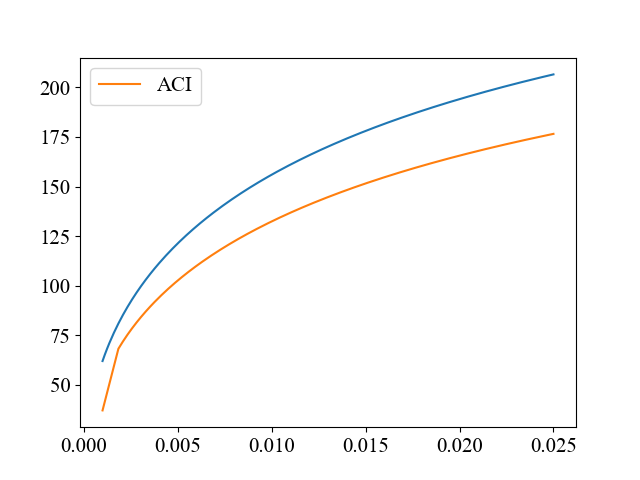

In [60]:
fig, ax = plt.subplots()
rho_list = np.linspace(0.1/100, 2.5/100, 200)
A_f_list = rho_list * 200 * 280
get_M_n = sp.lambdify(A_f, M_n_2.subs({sigma_f:sigma_f_sol}).subs({rho_f:A_f/(b*d)}).subs(sigma_cy_cu_vals).subs({f_cm:48, b:200, d:280, f_fu:2500, E_f:158000, E_cc:EC2.get_E_cm(48-8), eps_cy:EC2.get_eps_c1(48-8), eps_cu:EC2.get_eps_cu1(48-8)}), 'numpy')

get_M_n_aci = np.zeros_like(rho_list)
for i, A_f_ in enumerate(A_f_list):
    get_M_n_aci[i] = ACI440.get_M_n(A_f=A_f_, f_fu=2500, E_f=158000, f_c=48, b=200, d=280)

ax.plot(rho_list, get_M_n(A_f_list)/1e6)
ax.plot(rho_list, get_M_n_aci, label='ACI')
ax.legend()

In [61]:
ACI440.get_rho_balanced(f_c=48, f_fu=2500, E_f=158000)

0.0018393513305793058

In [62]:
rho_fb.subs({sigma_f:sigma_f_sol, rho_f:A_f/(b*d)}).subs(sigma_cy_cu_vals).subs({f_cm:48, b:200, d:280, f_fu:2500, E_f:158000, E_cc:EC2.get_E_cm(48-8), eps_cy:EC2.get_eps_c1(48-8), eps_cu:EC2.get_eps_cu1(48-8)})

0.00255381989675629

### Validation with experiments

**BC2HA** beam from Thériault1998_Effects of FRP Reinforcement Ratio and Concrete Strength on Flexural Behavior of Concrete Beams.pdf

M_u_experiment = 19.7 kNm

M_u_model = 19.7 kNm !!!

M_u_aci = 16 kNm !!!

In [63]:
sp.N(M_n_2.subs({sigma_f:sigma_f_}).subs(sigma_cy_cu_vals).subs({f_cm:57.2, b:130, d:180-20-6-12.3/2, f_fu:773, E_f:38000,  rho_f:2*np.pi*(12.3/2)**2/(130*(180-20-6-12.3/2)), A_f:2*np.pi*(12.3/2)**2, E_cc:EC2.get_E_cm(57.2-8), eps_cy:EC2.get_eps_c1(57.2-8), eps_cu:EC2.get_eps_cu1(57.2-8)}) / 1e6)

19.7172786302442

In [64]:
ACI440.get_M_n(A_f=2*np.pi*(12.3/2)**2, f_fu=773, E_f=38000, f_c=57.2, b=130, d=180-20-6-12.3/2)

16.014750484294655

### Reduce and print formula

In [65]:
# packaging common terms
M_n_2_reduced = sp.cse(M_n_2)
M_n_2_reduced

([(x0, E_\mathrm{f}*\varepsilon_\mathrm{cu} + \sigma_\mathrm{f}),
  (x1, \sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}),
  (x2, \varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}),
  (x3, \sigma_\mathrm{cy}*x2),
  (x4,
   \sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}),
  (x5, x1 + x3 + x4)],
 [-A_\mathrm{f}*\sigma_\mathrm{f}*d*(E_\mathrm{f}*(x1*(3*\varepsilon_\mathrm{cu} - 2*\varepsilon_\mathrm{cy}) + x2*(2*x3 + x4)) - 3*x0*x5)/(3*x0*x5)])

In [66]:
M_n_2_reduced[-1][0]

-A_\mathrm{f}*\sigma_\mathrm{f}*d*(E_\mathrm{f}*(x1*(3*\varepsilon_\mathrm{cu} - 2*\varepsilon_\mathrm{cy}) + x2*(2*x3 + x4)) - 3*x0*x5)/(3*x0*x5)

In [67]:
symb_exp_list = [[s, e] for (s, e) in M_n_2_reduced[0]]
for symb_exp in symb_exp_list:
    symb_exp[1] = symb_exp[1].subs({s:e for (s, e) in symb_exp_list})
symb_exp_list

[[x0, E_\mathrm{f}*\varepsilon_\mathrm{cu} + \sigma_\mathrm{f}],
 [x1, \sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}],
 [x2, \varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}],
 [x3, \sigma_\mathrm{cy}*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy})],
 [x4,
  \sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}],
 [x5,
  \sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy})]]

In [68]:
d_eps = sp.symbols(r'\varepsilon_{\Delta}')
M_n_2_reduced_final = sp.simplify(M_n_2_reduced[-1][0].subs({sym: exp for sym, exp in symb_exp_list[:-1]}).subs({eps_cu - eps_cy: d_eps}))
M_n_2_reduced_final

-A_\mathrm{f}*\sigma_\mathrm{f}*d*(E_\mathrm{f}*(\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}*(3*\varepsilon_\mathrm{cu} - 2*\varepsilon_\mathrm{cy}) + \varepsilon_{\Delta}*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*\varepsilon_{\Delta})) - 3*x5*(E_\mathrm{f}*\varepsilon_\mathrm{cu} + \sigma_\mathrm{f}))/(3*x5*(E_\mathrm{f}*\varepsilon_\mathrm{cu} + \sigma_\mathrm{f}))

In [69]:
x5_final = sp.simplify(symb_exp_list[5][1].subs({eps_cu: d_eps + eps_cy}))
x5_final

\sigma_\mathrm{cu}*\varepsilon_{\Delta} + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*\varepsilon_{\Delta}

In [70]:
sp.simplify(M_n_2_reduced[-1][0].subs({sym: exp for sym, exp in symb_exp_list[:-1]}).subs({eps_cu - eps_cy: d_eps}))

-A_\mathrm{f}*\sigma_\mathrm{f}*d*(E_\mathrm{f}*(\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}*(3*\varepsilon_\mathrm{cu} - 2*\varepsilon_\mathrm{cy}) + \varepsilon_{\Delta}*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*\varepsilon_{\Delta})) - 3*x5*(E_\mathrm{f}*\varepsilon_\mathrm{cu} + \sigma_\mathrm{f}))/(3*x5*(E_\mathrm{f}*\varepsilon_\mathrm{cu} + \sigma_\mathrm{f}))

In [71]:
sp.print_latex(M_n_2_reduced_final)

- \frac{A_\mathrm{f} \sigma_\mathrm{f} d \left(E_\mathrm{f} \left(\sigma_\mathrm{cy} \varepsilon_\mathrm{cy} \left(3 \varepsilon_\mathrm{cu} - 2 \varepsilon_\mathrm{cy}\right) + \varepsilon_{\Delta} \left(\sigma_\mathrm{cu} \varepsilon_\mathrm{cu} - \sigma_\mathrm{cu} \varepsilon_\mathrm{cy} + 2 \sigma_\mathrm{cy} \varepsilon_{\Delta}\right)\right) - 3 x_{5} \left(E_\mathrm{f} \varepsilon_\mathrm{cu} + \sigma_\mathrm{f}\right)\right)}{3 x_{5} \left(E_\mathrm{f} \varepsilon_\mathrm{cu} + \sigma_\mathrm{f}\right)}


In [72]:
sp.print_latex(x5_final)

\sigma_\mathrm{cu} \varepsilon_{\Delta} + \sigma_\mathrm{cy} \varepsilon_\mathrm{cy} + \sigma_\mathrm{cy} \varepsilon_{\Delta}


### Final $M_u$ formula

For $\rho_\mathrm{f} > \rho_\mathrm{f, cy}$, flexural capacity is given

$M_\mathrm{u,cu} = \frac{A_{f} d f_{f} 
\bigg(
3 m_0 \left(E_{f} \varepsilon_{cu} + f_{f}\right) 
- E_{f} \big(\Delta\varepsilon^2 \left(2 f_{cm_{cy}} + f_{cm_{cu}} \right)
~+~f_{cm_{cy}} \varepsilon_{cy} \left(3 \varepsilon_{cu} - 2 \varepsilon_{cy}\right)\big)\bigg)}
{3 m_0 \left(E_{f} \varepsilon_{cu} + f_{f}\right)}$

with

$m_0 = \Delta\varepsilon f_{cm_{cu}} + \Delta\varepsilon f_{cm_{cy}} + f_{cm_{cy}} \varepsilon_{cy}$

and

$\Delta\varepsilon = \varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}$

<!-- \begin{align}
m_1 & = \sqrt{E_\mathrm{f}} b d f_\mathrm{cm, cy}, \\
m_2 & =  E_f \Bigg( \sqrt{A_\mathrm{f} \varepsilon_\mathrm{cy} \cdot \bigg(A_\mathrm{f} E_\mathrm{f} \varepsilon_\mathrm{cy} + \frac{2 m_1}{\sqrt{E_\mathrm{f}}}\bigg)} + A_\mathrm{f}~\varepsilon_\mathrm{cy}~\sqrt{E_\mathrm{f}} \Bigg)
\end{align} -->

Note: this formula is exact for $\rho_\mathrm{f} > \rho_\mathrm{fb}$, but for $\rho_\mathrm{f, cy} < \rho_\mathrm{f} < \rho_\mathrm{fb}$ it's a conservative approx. considering the whole concrete block which gives larger ce resulting in smaller M_u

## Ultimate curvature $\kappa$ for part 2 with $\varepsilon_c = \varepsilon_{cu}$ ($\rho_f \ge \rho_{fb}$)

Valid for $\rho_f \ge \rho_{fb}$

In [73]:
kappa_2 = eps_cu / c2
kappa_2

(\varepsilon_\mathrm{cu} + \sigma_\mathrm{f}/E_\mathrm{f})/d

In [74]:
# From MK tool I get almost 8.75 * 1e-5
sp.N(kappa_2.subs({sigma_f:sigma_f_sol}).subs(sigma_cy_cu_vals).subs(test_vals))

8.58085379317477e-5

## Ultimate curvature for $\rho_{f, cy} < \rho_f < \rho_{fb}$
A linear interpolation is done between k1 and k2

In [75]:
kappa_1_symb, kappa_2_symb, rho_f_cy_symb, rho_fb_symb, kappa_u = sp.symbols(r'\kappa_\mathrm{u1}, \kappa_\mathrm{u2}, \rho_\mathrm{fcy}, \rho_\mathrm{fb}, \kappa_u', real=True, nonnegative=True)

kappa_u_cy_fb = sp.Line(sp.Point(rho_f_cy_symb, kappa_1_symb), sp.Point(rho_fb_symb, kappa_2_symb))
kappa_u_cy_fb_eq = kappa_u_cy_fb.equation(x=rho_f, y=kappa_u)
kappa_u_cy_fb_eq_sol = sp.simplify(sp.solve(kappa_u_cy_fb_eq, kappa_u)[0])
kappa_u_cy_fb_eq_sol

(\kappa_\mathrm{u1}*\rho_\mathrm{fb} - \kappa_\mathrm{u1}*\rho_\mathrm{f} - \kappa_\mathrm{u2}*\rho_\mathrm{fcy} + \kappa_\mathrm{u2}*\rho_\mathrm{f})/(\rho_\mathrm{fb} - \rho_\mathrm{fcy})

# Summary

## Moment capacity

Calculate $\rho_\mathrm{f,cy}$ as:

$
\rho_\mathrm{f,cy} = \frac{E_\mathrm{f} \sigma_\mathrm{cy} \varepsilon_\mathrm{cy}}{2 f_\mathrm{fu} \left(E_\mathrm{f} \varepsilon_\mathrm{cy} + f_\mathrm{fu}\right)}$

The ultimate flexural moment is given:

\begin{equation*}
  M_\mathrm{u}=
  \begin{cases}
      M_\mathrm{u,cy},
    & \rho_\mathrm{f} \le \rho_\mathrm{f,cy}\\
      M_\mathrm{u,cu},
    & \rho_\mathrm{f} > \rho_\mathrm{f,cy}.
  \end{cases}
\end{equation*}

### $M_\mathrm{u,cy}$

$M_\mathrm{u,cy} = \frac{A_\mathrm{f} d f_\mathrm{fu} \left(3 m_{1} + 2 m_{2}\right)}{3 \left(m_{1} + m_{2}\right)}$

with

\begin{align}
m_1 & = \sqrt{E_\mathrm{f}} b d \sigma_\mathrm{cy}, \\
m_2 & =  E_f \Bigg( \sqrt{A_\mathrm{f} \varepsilon_\mathrm{cy} \cdot \bigg(A_\mathrm{f} E_\mathrm{f} \varepsilon_\mathrm{cy} + \frac{2 m_1}{\sqrt{E_\mathrm{f}}}\bigg)} + A_\mathrm{f}~\varepsilon_\mathrm{cy}~\sqrt{E_\mathrm{f}} \Bigg), \\
\sigma_\mathrm{cy} & = 10^{-3} f_\mathrm{cm} \cdot (1437.6204 - 2.7858 f_\mathrm{cm})
\end{align}

and according to EC2

$\varepsilon_\mathrm{cy} = 0.001 \cdot \min\left(2.8,~0.7 f_\mathrm{cm}^{0.31}\right)$

In [76]:
f_cm * sig_cy_scale

f_\mathrm{cm}*(1.43762037986179 - 0.00278582241716739*f_\mathrm{cm})

In [77]:
sp.print_latex(sig_cy_scale * 1000)

1437.62037986179 - 2.78582241716739 f_\mathrm{cm}


### $M_\mathrm{u,cu}$
Note: this formula is exact for $\rho_\mathrm{f} > \rho_\mathrm{fb}$, but for $\rho_\mathrm{f, cy} < \rho_\mathrm{f} < \rho_\mathrm{fb}$ it's a conservative approx. considering the whole concrete block which gives larger $ce$ resulting in smaller M_u

$M_\mathrm{u,cu} = \frac{A_\mathrm{f} d \sigma_\mathrm{f} 
\bigg(
3 m_0 \left(E_\mathrm{f} \varepsilon_\mathrm{cu} + \sigma_\mathrm{f}\right) 
~ - ~E_\mathrm{f} \big(\Delta\varepsilon^2 \left(2 \sigma_\mathrm{cy} + \sigma_\mathrm{cu} \right)
~+~\sigma_\mathrm{cy} \varepsilon_\mathrm{cy} \left(3 \varepsilon_\mathrm{cu} - 2 \varepsilon_\mathrm{cy}\right)\big)\bigg)}
{3 m_0 \left(E_\mathrm{f} \varepsilon_\mathrm{cu} + \sigma_\mathrm{f}\right)}$

with

$\Delta\varepsilon = \varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}$

and

$m_0 = \Delta\varepsilon \sigma_\mathrm{cu} + \Delta\varepsilon \sigma_\mathrm{cy} + \sigma_\mathrm{cy} \varepsilon_\mathrm{cy}$

$\sigma_\mathrm{f} = \min\left(f_\mathrm{fu},~0.5 \bigg( \sqrt{\frac{E_\mathrm{f} \cdot \big(E_\mathrm{f} \rho_\mathrm{f} \varepsilon_\mathrm{cu}^2~+~2 \sigma_\mathrm{cu} \Delta\varepsilon~+~2 \sigma_\mathrm{cy} \varepsilon_\mathrm{cu} \big)}
{\rho_\mathrm{f}}}
- E_{f} \varepsilon_\mathrm{cu}\bigg) \right)$

$\sigma_\mathrm{cu} = 10^{-3} f_\mathrm{cm} \cdot (8.2275 f_\mathrm{cm} + 95.5314)$

and

\begin{equation*}
  \varepsilon_\mathrm{cu}= 0.001 \cdot
  \begin{cases}
      3.5 ,
    & f_\mathrm{cm} \le 58~\mathrm{MPa} \\
    2.8 + 27 \cdot \big(\frac{98 - f_\mathrm{cm}}{100}\big)^4,
    & 58~\mathrm{MPa} < f_\mathrm{cm} \boldsymbol{\le 98~\mathrm{MPa}}\\
    \boldsymbol{2.8,}
    & \boldsymbol{f_\mathrm{cm} > 98~\mathrm{MPa}}.
  \end{cases}
\end{equation*}

The bold marked text is an adaptation to EC2 formula.

In [78]:
f_cm * sig_cu_scale

f_\mathrm{cm}*(0.00822753426311965*f_\mathrm{cm} + 0.0955313938528226)

In [79]:
sp.print_latex(sig_cu_scale * 1000)

8.22753426311965 f_\mathrm{cm} + 95.5313938528226


In [80]:
sp.print_latex(rho_fb)

\frac{E_\mathrm{f} \left(\sigma_\mathrm{cu} \varepsilon_\mathrm{cu} - \sigma_\mathrm{cu} \varepsilon_\mathrm{cy} + \sigma_\mathrm{cy} \varepsilon_\mathrm{cu}\right)}{2 f_\mathrm{fu} \left(E_\mathrm{f} \varepsilon_\mathrm{cu} + f_\mathrm{fu}\right)}


## Balanced reinforcement ratio $\rho_\mathrm{fb}$

$\rho_\mathrm{fb} = \frac{E_\mathrm{f} \left(\sigma_\mathrm{cu} \varepsilon_\mathrm{cu}~-~\sigma_\mathrm{cu} \varepsilon_\mathrm{cy}~+~\sigma_\mathrm{cy} \varepsilon_\mathrm{cu}\right)}{2 f_\mathrm{fu} \left(E_\mathrm{f} \varepsilon_\mathrm{cu}~+~f_\mathrm{fu}\right)}
$

## Material utilization factors ($\psi_\mathrm{c}~and~\psi_\mathrm{f}$)

\begin{equation*}
  \psi_\mathrm{c} =
  \begin{cases}
\min\left(
1,~
\frac{f_\mathrm{fu}}{f_\mathrm{cm}} \bigg(\rho_\mathrm{f} + \sqrt{\frac{\rho_\mathrm{f} \left(\rho_\mathrm{f} E_\mathrm{f} \varepsilon_{cy}~+~2 \sigma_\mathrm{cy}\right)}
{E_\mathrm{f} \varepsilon_\mathrm{cy}}} \bigg)\right)
,
    & \rho_\mathrm{f} < \rho_\mathrm{f,cy}\\
      1,
    & \rho_\mathrm{f} \ge \rho_\mathrm{f,cy}.
  \end{cases}
\end{equation*}


\begin{equation*}
  \psi_\mathrm{f} =
  \begin{cases}
      \frac{\sigma_\mathrm{f}}{f_\mathrm{fu}},
    & \rho_\mathrm{f} > \rho_\mathrm{fb}\\
      1,
    & \rho_\mathrm{f} \le \rho_\mathrm{fb}.
  \end{cases}
\end{equation*}

Notice that material utilization is optimal ($\psi_c = 1, \psi_f = 1$) for $\rho_\mathrm{f,cy} < \rho_\mathrm{f} < \rho_\mathrm{fb}$.

In [81]:
sp.simplify(psi_c.args[1].subs({A_f:rho_f * b * d}))

sqrt(\rho_\mathrm{f})*f_\mathrm{fu}*sqrt(E_\mathrm{f}*\rho_\mathrm{f}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy})/(sqrt(E_\mathrm{f})*\sigma_\mathrm{cy}*sqrt(\varepsilon_\mathrm{cy}))

# For a given $M_u$, solve for different parameters to get optimally utilized section

An optimally utilized section is a section with reinforcement ratio $\rho_\mathrm{f, cy} \le \rho \le \rho_\mathrm{fb}$

We substitute these limit reinforcement ratio in $M_n$ formula and solve for different parameters to find, for each parameter, a range that makes the section optimally utilized

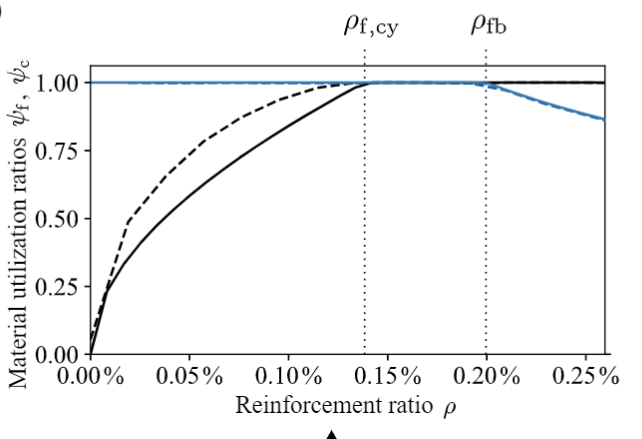

In [82]:
M_n = sp.Symbol('M_n')

In [83]:
M_n_2_fb = M_n_2.subs(A_f, rho_fb * b * d).subs(sigma_f, f_fu)
M_n_2_cy = M_n_2.subs(A_f, rho_f_cy * b * d).subs(sigma_f, f_fu)

## $d$ range that ensures an optimal cross-section

Notice: if reinforcement ratio is higher then lower $d$ is needed, therefore $d$ corresponding to $\rho_\mathrm{fb}$ is the *min*

### Lower limit for $d$

In [84]:
d_min = sp.simplify(sp.solve(M_n_2_fb - M_n, d)[1])
d_min

sqrt(6)*sqrt(M_n/(E_\mathrm{f}*b*(2*E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}**2 - E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}*\varepsilon_\mathrm{cy} - E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}**2 + E_\mathrm{f}*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cu}**2 + E_\mathrm{f}*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cu}*\varepsilon_\mathrm{cy} + 3*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}*f_\mathrm{fu} - 3*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}*f_\mathrm{fu} + 3*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cu}*f_\mathrm{fu})))*(E_\mathrm{f}*\varepsilon_\mathrm{cu} + f_\mathrm{fu})

In [85]:
sp.cse(d_min)

([(x0, E_\mathrm{f}*\varepsilon_\mathrm{cu}),
  (x1, 3*f_\mathrm{fu}),
  (x2, \varepsilon_\mathrm{cu}*x1),
  (x3, \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}),
  (x4, E_\mathrm{f}*\varepsilon_\mathrm{cu}**2)],
 [sqrt(6)*sqrt(M_n/(E_\mathrm{f}*b*(-E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}**2 + \sigma_\mathrm{cu}*x2 + 2*\sigma_\mathrm{cu}*x4 + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}*x0 + \sigma_\mathrm{cy}*x2 + \sigma_\mathrm{cy}*x4 - x0*x3 - x1*x3)))*(f_\mathrm{fu} + x0)])

### Upper limit for $d$

In [86]:
d_max = sp.simplify(sp.solve(M_n_2_cy - M_n, d)[1])
# or
# d_max = sp.solve(M_n_1.subs(A_f, rho_f_cy * b * d) - M_n, d)[1]
d_max

sqrt(6)*sqrt(M_n*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}**2*f_\mathrm{fu}/(\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}) + \sigma_\mathrm{cu}*(E_\mathrm{f}*\varepsilon_\mathrm{cu}**2 - E_\mathrm{f}*\varepsilon_\mathrm{cu}*\varepsilon_\mathrm{cy} - \varepsilon_\mathrm{cy}*f_\mathrm{fu})/\sigma_\mathrm{cy} + \varepsilon_\mathrm{cu}**2*f_\mathrm{fu}/\varepsilon_\mathrm{cy} + \varepsilon_\mathrm{cu}*(E_\mathrm{f}*\varepsilon_\mathrm{cu} + f_\mathrm{fu}) + \sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}*f_\mathrm{fu}**2/(E_\mathrm{f}*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}) - \sigma_\mathrm{cu}*f_\mathrm{fu}**2/(E_\mathrm{f}*\sigma_\mathrm{cy}) + \varepsilon_\mathrm{cu}*f_\mathrm{fu}**2/(E_\mathrm{f}*\varepsilon_\mathrm{cy}))/(b*(2*E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}**2 - E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}*\varepsilon_\mathrm{cy} - E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}**2 + E_\mathrm{f}*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cu}**2 

In [87]:
sp.cse(d_max)[-1][0]

sqrt(6)*sqrt(M_n*(\varepsilon_\mathrm{cu}*(f_\mathrm{fu} + x3) + x10*x11 + x10 + x11*x8 - x11*x9 + x11*(E_\mathrm{f}*x5 - x2 - x4) + x8)/(b*(-E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}**2 - \sigma_\mathrm{cu}*x4 + 2*\sigma_\mathrm{cu}*x6 + 3*\sigma_\mathrm{cy}*x1 + \sigma_\mathrm{cy}*x4 + \sigma_\mathrm{cy}*x6 + x0*x1 - x0*x2)))

## $b$ range that ensures an optimal cross-section

### Lower limit for $b$

In [88]:
b_min = sp.simplify(sp.solve(M_n_2_fb - M_n, b)[0])
b_min

6*M_n*(E_\mathrm{f}*\varepsilon_\mathrm{cu} + f_\mathrm{fu})**2/(E_\mathrm{f}*d**2*(2*E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}**2 - E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}*\varepsilon_\mathrm{cy} - E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}**2 + E_\mathrm{f}*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cu}**2 + E_\mathrm{f}*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cu}*\varepsilon_\mathrm{cy} + 3*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}*f_\mathrm{fu} - 3*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}*f_\mathrm{fu} + 3*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cu}*f_\mathrm{fu}))

In [89]:
sp.cse(b_min)

([(x0, E_\mathrm{f}*\varepsilon_\mathrm{cu}),
  (x1, 3*f_\mathrm{fu}),
  (x2, \varepsilon_\mathrm{cu}*x1),
  (x3, \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}),
  (x4, E_\mathrm{f}*\varepsilon_\mathrm{cu}**2)],
 [6*M_n*(f_\mathrm{fu} + x0)**2/(E_\mathrm{f}*d**2*(-E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}**2 + \sigma_\mathrm{cu}*x2 + 2*\sigma_\mathrm{cu}*x4 + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}*x0 + \sigma_\mathrm{cy}*x2 + \sigma_\mathrm{cy}*x4 - x0*x3 - x1*x3))])

### Upper limit for $b$

In [90]:
b_max = sp.simplify(sp.solve(M_n_2_cy - M_n, b)[0])
# or
# b_max = sp.simplify(sp.solve(M_n_1.subs(A_f, rho_f_cy * b * d) - M_n, b)[0])
b_max

6*M_n*(E_\mathrm{f}**2*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}**2*\varepsilon_\mathrm{cy} - E_\mathrm{f}**2*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}*\varepsilon_\mathrm{cy}**2 + E_\mathrm{f}**2*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cu}**2*\varepsilon_\mathrm{cy} + E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}**2*f_\mathrm{fu} - E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}**2*f_\mathrm{fu} + E_\mathrm{f}*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cu}**2*f_\mathrm{fu} + E_\mathrm{f}*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cu}*\varepsilon_\mathrm{cy}*f_\mathrm{fu} + \sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}*f_\mathrm{fu}**2 - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}*f_\mathrm{fu}**2 + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cu}*f_\mathrm{fu}**2)/(E_\mathrm{f}*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}*d**2*(2*E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}**2 - E_\mathrm{f}*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}*\varepsilon_\mathrm{cy} - E_\mathrm{f}*\s

In [91]:
sp.cse(b_max)

([(x0, 3*f_\mathrm{fu}),
  (x1, \varepsilon_\mathrm{cu}*x0),
  (x2, \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy}),
  (x3, \varepsilon_\mathrm{cu}*\varepsilon_\mathrm{cy}),
  (x4, E_\mathrm{f}*\sigma_\mathrm{cy}*x3),
  (x5, \varepsilon_\mathrm{cu}**2),
  (x6, E_\mathrm{f}*x5),
  (x7, \sigma_\mathrm{cy}*x6),
  (x8, E_\mathrm{f}*\sigma_\mathrm{cu}),
  (x9, \sigma_\mathrm{cu}*x6),
  (x10, \varepsilon_\mathrm{cy}**2),
  (x11, x10*x8),
  (x12, f_\mathrm{fu}**2),
  (x13, \varepsilon_\mathrm{cu}*x12),
  (x14, E_\mathrm{f}**2),
  (x15, x14*x5)],
 [6*M_n*(-\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu}*x10*x14 + \sigma_\mathrm{cu}*x13 + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}*x15 + \sigma_\mathrm{cy}*x13 - f_\mathrm{fu}*x11 + f_\mathrm{fu}*x4 + f_\mathrm{fu}*x7 + f_\mathrm{fu}*x9 - x12*x2 + x15*x2)/(E_\mathrm{f}*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}*d**2*(\sigma_\mathrm{cu}*x1 + \sigma_\mathrm{cy}*x1 - x0*x2 - x11 - x3*x8 + x4 + x7 + 2*x9))])

### Dimensionless efficient design diagram

In [92]:
M_n_2_fb

-E_\mathrm{f}*b*d**2*(E_\mathrm{f}*(\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}*(3*\varepsilon_\mathrm{cu} - 2*\varepsilon_\mathrm{cy}) + (\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy})*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}))) - 3*(E_\mathrm{f}*\varepsilon_\mathrm{cu} + f_\mathrm{fu})*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy})))*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cu})/(6*(E_\mathrm{f}*\varepsilon_\mathrm{cu} + f_\mathrm{fu})**2*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*(\varepsilon_\mathrm{cu} -

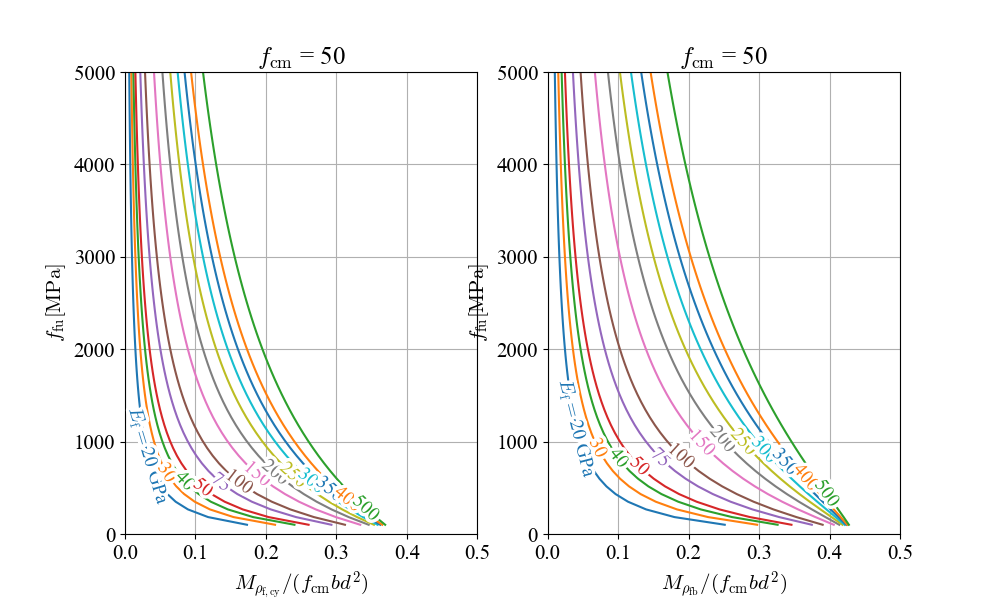

In [133]:
# TODO what if we used a normalized omega = E_f / f_fu, but a magnitude is needed, this might be not possible
# TODO check the todo below

from labellines import labelLine, labelLines

M_n_2_cy_norm = M_n_2_cy / (f_cm * b*d**2)
M_n_2_fb_norm = M_n_2_fb / (f_cm * b*d**2)

# f_cms = [30, 50, 90]
f_cms = [50]
f_fus = np.linspace(100, 5000, 60)
# E_fs = np.linspace(30000, 500000, 10)
E_fs = np.array([20, 30, 40, 50, 75, 100, 150, 200, 250, 300, 350, 400, 500]) * 1000
M_n_2_cy_norm_vals = np.zeros((len(f_cms), len(E_fs), len(f_fus)))
M_n_2_fb_norm_vals = np.zeros((len(f_cms), len(E_fs), len(f_fus)))

for f_cm_i, f_cm_val in enumerate(f_cms):
    for E_j, E_f_val in enumerate(E_fs):
        for f_i, f_fu_val in enumerate(f_fus):
            t1_mat_params = {
                  f_cm:f_cm_val,
                  f_fu:f_fu_val, 
                  E_f:E_f_val, 
                  eps_cy:EC2.get_eps_c1(f_cm_val-8), # TODO one of these is adapted and not exacly like EC2
                  eps_cu:EC2.get_eps_cu1(f_cm_val-8) # TODO one of these is adapted and not exacly like EC2
                 }
            M_n_2_cy_norm_vals[f_cm_i, E_j, f_i] = sp.N(M_n_2_cy_norm.subs(sigma_cy_cu_vals).subs(t1_mat_params))
            M_n_2_fb_norm_vals[f_cm_i, E_j, f_i] = sp.N(M_n_2_fb_norm.subs(sigma_cy_cu_vals).subs(t1_mat_params))

fig, axes = plt.subplots(len(f_cms), 2, figsize=(10, len(f_cms) * 6))

for f_cm_i, f_cm_val in enumerate(f_cms):
    ax1 = axes[f_cm_i, 0] if len(f_cms) > 1 else axes[0]
    ax2 = axes[f_cm_i, 1] if len(f_cms) > 1 else axes[1]
    ax1.set_xlabel(r'$M_{\rho_\mathrm{f, cy}}/(f_\mathrm{cm} bd^2)$')
    ax2.set_xlabel(r'$M_{\rho_\mathrm{fb}}/(f_\mathrm{cm} bd^2)$')
    title = r'$f_\mathrm{cm}$ = ' + str(f_cm_val)
    ax1.set_title(title); ax2.set_title(title)
    for i, E_f_val in enumerate(E_fs):
        label = r'$E_\mathrm{f} = $' + str(int(E_f_val/1000)) + ' GPa' if i==0 else str(round(E_f_val/1000))
        ax1.plot(M_n_2_cy_norm_vals[f_cm_i, i, :], f_fus, label=label)
        ax2.plot(M_n_2_fb_norm_vals[f_cm_i, i, :], f_fus, label=label)

for ax in axes.flatten():
    labelLines(ax.get_lines(), align=True, fontsize=14, zorder=12.5, yoffsets=0.1)
    ax.set_xlim(0, 0.5)
    ax.set_ylim(0, np.max(f_fus))
    ax.set_ylabel(r'$f_\mathrm{fu} \mathrm{[MPa]}$')
    ax.grid()
#     ax.legend()


## Tests

In [94]:
f_cm_val = 98.6
test_vals1 = {f_cm:f_cm_val, 
              b:300, 
              d:90, 
              f_fu:3823.9, 
              E_f:247469, 
#             A_f:250, 
#             rho_f:250/(180*400),
            E_cc:EC2.get_E_cm(f_cm_val-8), 
            eps_cy:EC2.get_eps_c1(f_cm_val-8),
           eps_cu:EC2.get_eps_cu1(f_cm_val-8)
             }
# test_vals1[d] = 185
# test_vals1[A_f] = rho_fb_test * test_vals1[b] * test_vals1[d]
# test_vals1[rho_f] = rho_fb_test
test_vals1

{f_\mathrm{cm}: 98.6,
 b: 300,
 d: 90,
 f_\mathrm{fu}: 3823.9,
 E_\mathrm{f}: 247469,
 E_\mathrm{cc}: 43710.49808123633,
 \varepsilon_\mathrm{cy}: 0.0028,
 \varepsilon_\mathrm{cu}: 0.0028000000349919997}

$b$ range

In [95]:
sp.N(b_min.subs(sigma_cy_cu_vals).subs(test_vals1).subs(M_n, 100e6)) # with rho_fb

1479.31492447447

In [96]:
sp.N(b_max.subs(sigma_cy_cu_vals).subs(test_vals1).subs(M_n, 100e6)) # with rho_f_cy

1479.31495454045

In [97]:
rho_f_cy.subs(sigma_cy_cu_vals).subs(test_vals1)

0.00230008437353020

In [98]:
rho_fb.subs(sigma_cy_cu_vals).subs(test_vals1)

0.00230008442027771

$d$ range

In [99]:
sp.N(d_min.subs(sigma_cy_cu_vals).subs(test_vals1).subs(M_n, 100e6)) # with rho_fb

199.853703895651

In [100]:
sp.N(d_max.subs(sigma_cy_cu_vals).subs(test_vals1).subs(M_n, 100e6)) # with rho_f_cy

199.853705926590

In [101]:
rho_range = np.linspace(0.002057, 0.0032032, 50)
b_range = np.linspace(658.33585, 422.8495, 50)
d_range = np.linspace(230.9225, 185.069, 50)

In [102]:
M_us = np.zeros_like(rho_range)
i = 0
for rho, b_val in zip(rho_range, b_range):
    M_u = AnaFRPBending(f_cm = 50, E_f = 200000, f_fu = 2500, b=b_val, d=180, A_f=rho * b_val * 180).M_u
    M_us[i] = M_u
    i += 1
M_us

array([103.89640643, 100.37801283, 100.76021245, 101.1258127 ,
       101.47481356, 101.80721504, 102.12301714, 102.42221986,
       102.7048232 , 102.97082716, 103.22023173, 103.45303692,
       103.66924274, 103.86884917, 104.05185622, 104.21826389,
       104.36807218, 104.50128109, 104.61789061, 104.71790076,
       104.80131152, 104.8681229 , 104.9183349 , 104.95194752,
       104.96896076, 104.96937462, 104.9531891 , 104.92040419,
       104.8710199 , 104.80503624, 104.72245319, 104.62327076,
       104.50748895, 104.37510776, 104.22612718, 104.06054723,
       103.87836789, 103.67958918, 103.46421108, 103.2322336 ,
       102.98365674, 102.7184805 , 102.43670488, 102.13832987,
       101.82335549, 101.49178172, 101.14360857, 100.77883604,
       100.39746413,  99.99949284])

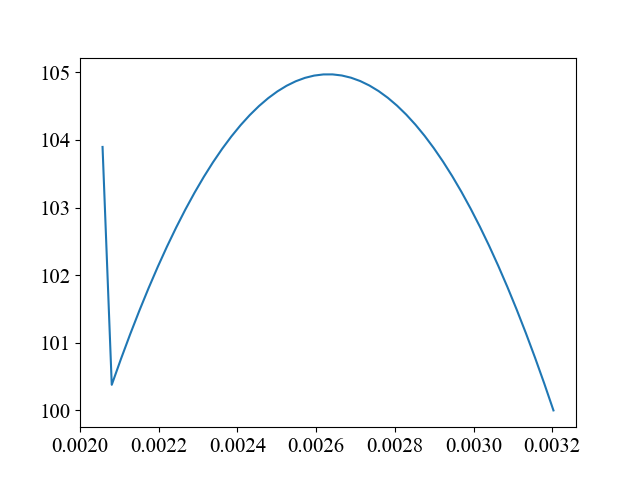

In [103]:
fig, ax = plt.subplots()
ax.plot(rho_range, M_us)

In [104]:
M_us = np.zeros_like(rho_range)
i = 0
for rho, d_val in zip(rho_range, d_range):
    M_u = AnaFRPBending(f_cm = 50, E_f = 200000, f_fu = 2500, b=400, d=d_val, A_f=rho * 400 * d_val).M_u
    M_us[i] = M_u
    i += 1
M_us

array([103.89640089, 100.29829255, 100.60234296, 100.89147176,
       101.16579095, 101.42541257, 101.67044864, 101.90101118,
       102.11721222, 102.31916378, 102.50697789, 102.68076657,
       102.84064185, 102.98671574, 103.11910028, 103.23790748,
       103.34324937, 103.43523798, 103.51398532, 103.57960343,
       103.63220433, 103.67190003, 103.69880258, 103.71302398,
       103.71467626, 103.70387145, 103.68072157, 103.64533865,
       103.59783471, 103.53832176, 103.46691185, 103.38371699,
       103.2888492 , 103.18242052, 103.06454296, 102.93532854,
       102.7948893 , 102.64333725, 102.48078442, 102.30734284,
       102.12312452, 101.9282415 , 101.72280579, 101.50692942,
       101.28072442, 101.04430281, 100.7977766 , 100.54125784,
       100.27485853,  99.99869071])

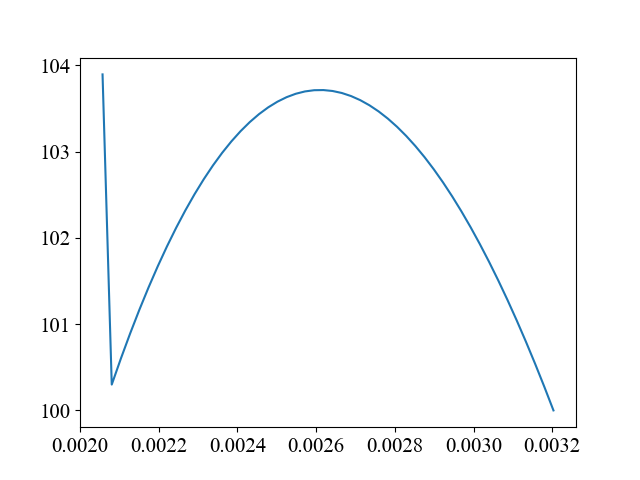

In [105]:
fig, ax = plt.subplots()
ax.plot(rho_range, M_us)

In [106]:
rho_fb_test = sp.N(rho_fb.subs(sigma_cy_cu_vals).subs(test_vals1))
rho_fb_test

0.00230008442027771

In [107]:
M_n_2.subs({sigma_f:sigma_f_})

-A_\mathrm{f}*d*(E_\mathrm{f}*(\sigma_\mathrm{cy}*\varepsilon_\mathrm{cy}*(3*\varepsilon_\mathrm{cu} - 2*\varepsilon_\mathrm{cy}) + (\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy})*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}))) - 3*(E_\mathrm{f}*\varepsilon_\mathrm{cu} + Min(f_\mathrm{fu}, sqrt(E_\mathrm{f})*sqrt(E_\mathrm{f}*\rho_\mathrm{f}*\varepsilon_\mathrm{cu}**2 + 2*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - 2*\sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + 2*\sigma_\mathrm{cy}*\varepsilon_\mathrm{cu})/(2*sqrt(\rho_\mathrm{f})) - E_\mathrm{f}*\varepsilon_\mathrm{cu}/2))*(\sigma_\mathrm{cu}*\varepsilon_\mathrm{cu} - \sigma_\mathrm{cu}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*\varepsilon_\mathrm{cy} + \sigma_\mathrm{cy}*(\varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy})))*Min(f_\mathrm{fu}, sqrt(E_\mathrm{f})*sqrt(E_\mathrm{f}*\rho_\mathrm{f}*\varepsilon_\ma

In [108]:
sp.N(M_n_2.subs({sigma_f:sigma_f_}).subs(sigma_cy_cu_vals).subs(test_vals1) / 1e6)

-9.34393113365082e-5*A_\mathrm{f}*(-0.963192030342326*Min(3823.9, 346.456604329718*(\rho_\mathrm{f} + 0.330967038965077)**0.5/\rho_\mathrm{f}**0.5 - 346.456604329718) - 444.938986254035)*Min(3823.9, 346.456604329718*(\rho_\mathrm{f} + 0.330967038965077)**0.5/\rho_\mathrm{f}**0.5 - 346.456604329718)/(Min(3823.9, 346.456604329718*(\rho_\mathrm{f} + 0.330967038965077)**0.5/\rho_\mathrm{f}**0.5 - 346.456604329718) + 692.913208659435)